In [91]:
import numpy as np
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

In [92]:
#Load EEG data and define non-standard channels (set up iterative loop once mne figured out)
raw = mne.io.read_raw_bdf("/Users/scottmcelroy/smm_code/sdlab_data/THC-IOM_for_Salva/TI001-SA244/Day 1/postTI001A20.bdf")
raw.load_data()
raw.pick(['eeg', 'eog', 'stim'])
raw.load_data()
raw.set_channel_types({'HEO1': 'eog'})
raw.set_channel_types({'HEO2': 'eog'})
raw.set_channel_types({'VEO1': 'eog'})
raw.set_channel_types({'VEO2': 'eog'})
#raw.set_eeg_reference(ref_channels=['M1', 'M2'])
raw.set_eeg_reference(ref_channels=['NOSE'])
raw.drop_channels(['M1', 'M2', 'NOSE', 'EXG8'])


Extracting EDF parameters from /Users/scottmcelroy/smm_code/sdlab_data/THC-IOM_for_Salva/TI001-SA244/Day 1/postTI001A20.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 64511  =      0.000 ...    62.999 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


<RawEDF | postTI001A20.bdf, 69 x 64512 (63.0 s), ~34.0 MB, data loaded>

In [93]:
raw.filter(0.1,100)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33793 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished


<RawEDF | postTI001A20.bdf, 69 x 64512 (63.0 s), ~34.0 MB, data loaded>

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>


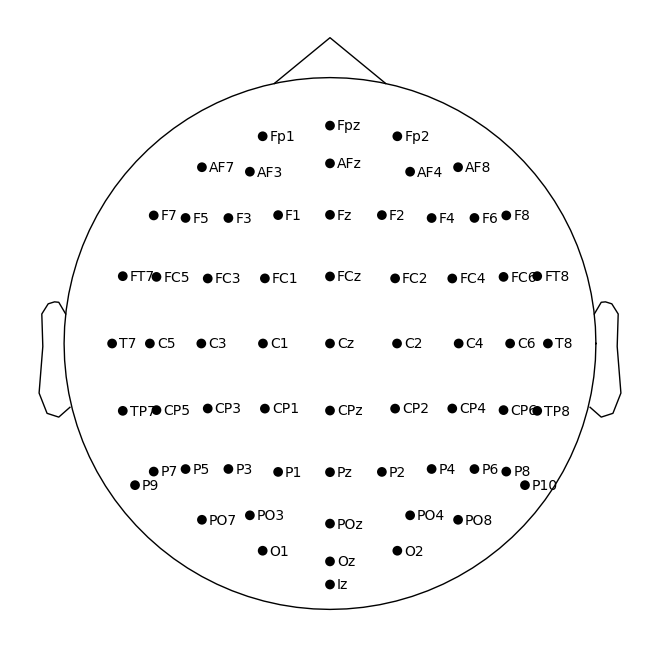

<RawEDF | postTI001A20.bdf, 69 x 64512 (63.0 s), ~34.1 MB, data loaded>

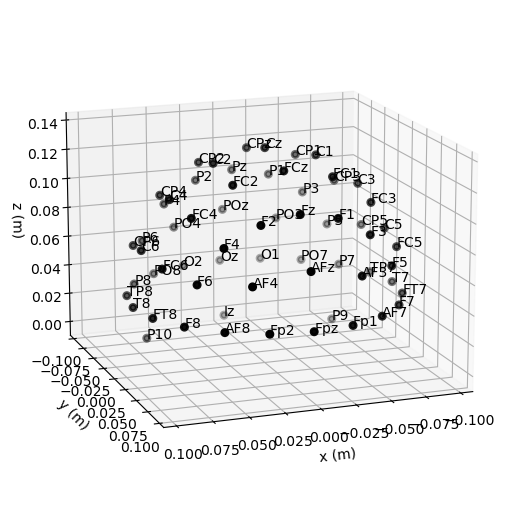

In [94]:
std_montage = mne.channels.make_standard_montage('biosemi64')
print(std_montage)
std_montage.plot()
fig = std_montage.plot(kind='3d', show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15) 
raw.set_montage(std_montage, on_missing='warn')

In [95]:
events = mne.find_events(raw)
event_id = {'EOG': 4}
epochs = mne.Epochs(raw, events, preload=True)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
51 events found
Event IDs: [    2     8   100   200 65663]
Not setting metadata
51 matching events found
Setting baseline interval to [-0.2001953125, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 718 original time points ...
0 bad epochs dropped


/var/folders/ps/wz07wlx570nb502ndwgmzwlc0000gn/T/ipykernel_54129/3573892833.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = epochs.average('all').plot(**plot_kwargs)


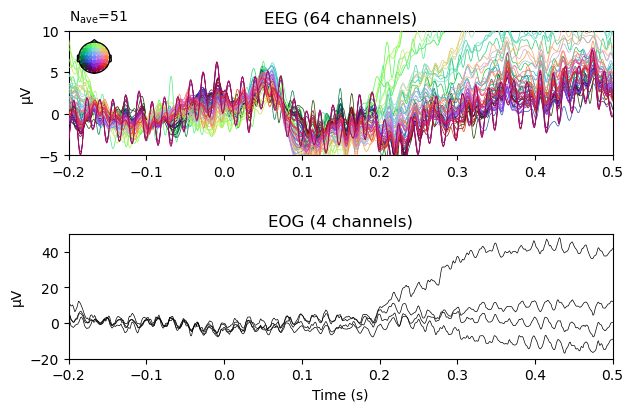

In [96]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks='all', ylim=dict(eeg=(-5, 10), eog=(-20, 50)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average('all').plot(**plot_kwargs)


In [97]:
#average_eog = create_eog_epochs(raw).average()
#average_eog.plot_joint(**plot_kwargs)

No projector specified for this dataset. Please consider the method self.add_proj.


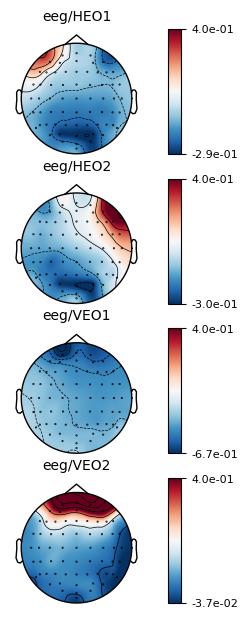

In [98]:
model_plain = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs)
fig = model_plain.plot(vlim=(None, 0.4)) # regression coefficients as topomap

No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


/var/folders/ps/wz07wlx570nb502ndwgmzwlc0000gn/T/ipykernel_54129/3575809213.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = epochs_clean_plain.average('all').plot(**plot_kwargs)


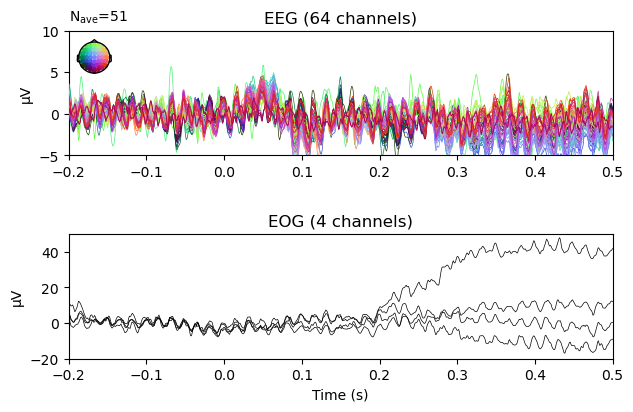

In [99]:
epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average('all').plot(**plot_kwargs)
fig.set_size_inches(6, 6)

Subtracting Evoked from Epochs
    The following channels are not included in the subtraction: VEO1, Status, VEO2, HEO2, HEO1
[done]
No projector specified for this dataset. Please consider the method self.add_proj.


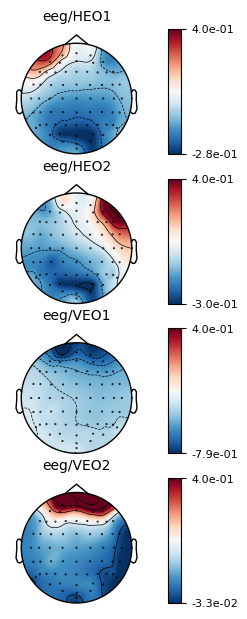

No projector specified for this dataset. Please consider the method self.add_proj.
Applying baseline correction (mode: mean)


/var/folders/ps/wz07wlx570nb502ndwgmzwlc0000gn/T/ipykernel_54129/2586119417.py:11: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = epochs_clean_sub.average('all').plot(**plot_kwargs)


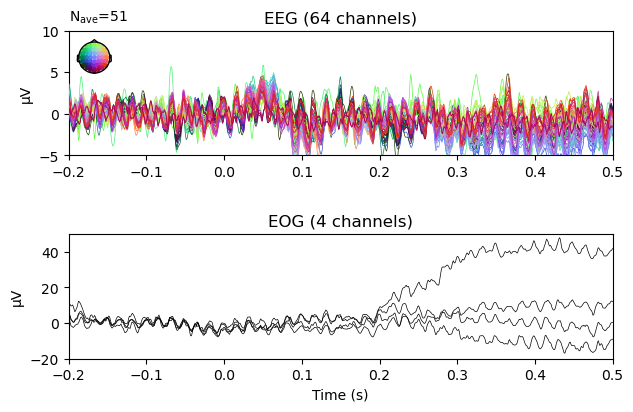

In [100]:
# create epochs with the evoked subtracted out
epochs_sub = epochs.copy().subtract_evoked()

# perform regression
model_sub = mne.preprocessing.EOGRegression(picks='eeg', picks_artifact='eog').fit(epochs_sub)
fig = model_sub.plot(vlim=(None, 0.4))
fig.set_size_inches(3, 2)

# apply the regression coefficients to the original epochs
epochs_clean_sub = model_plain.apply(epochs).apply_baseline()
fig = epochs_clean_sub.average('all').plot(**plot_kwargs)
fig.set_size_inches(6, 6)